In [1]:
import tensorflow as tf

from google.cloud import bigquery

### Defaults for the notebook - add your project information

In [2]:
# Use your unique Qwiklabs project ID as the value for the Project and Bucket variables
PROJECT = 'qwiklabs-gcp-01-b313f4deebe2'
DATASET = 'drl'
TABLE = 'pilot-event-times'

BUCKET = PROJECT

### Get the data from BigQuery Table

Using the BigQuery client library, use a SQL SELECT statement to get the data from your BigQuery table to a Pandas Dataframe.

In [3]:
df = bigquery.Client().query(f'SELECT pilot_id, ename, events_name, minimum_time, rank FROM `{PROJECT}.{DATASET}.{TABLE}`').to_dataframe()

### Split data into training and validation datasets
In this section, you will split the DRL table data into two subsets: a training subset and a validation subset.

You will use only the training data to train the model.

The validation dataset is similar to questions on a school test. You should not use them during model training so that you can get an independent evaluation of model quality by testing it on data it hasn't trained on.

In [4]:
val_dataframe = df.sample(frac=0.2, random_state=1337)
train_dataframe = df.drop(val_dataframe.index)

In [5]:
print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 647 samples for training and 162 for validation


### Change data format
Next, you will change the data format from Pandas Dataframe to Tensorflow Dataset in order to improve performance of the training. 

Tensorflow is able to work with Pandas Dataframe but it has performance limits. Additionally, [Tensorflow Datasets](https://www.tensorflow.org/datasets) has more tools to improve performance.

Run the next cell to convert your pandas dataframe with Drone Racing League pilot-event-times data to a TensorFlow Dataset.

In [7]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("rank")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [8]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'pilot_id': <tf.Tensor: shape=(), dtype=int64, numpy=15>, 'ename': <tf.Tensor: shape=(), dtype=string, numpy=b'Qualifier'>, 'events_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Miami Lights'>, 'minimum_time': <tf.Tensor: shape=(), dtype=float64, numpy=89.3>}
Target: tf.Tensor(1, shape=(), dtype=int64)


### Batch data
Batching is one improvement Tensorflow Datasets has over Pandas Dataframe. Batching improves speed of the training by combining more data into one computational cycle.

The following cell will batch 32 consecutive elements of both datasets into a single element:

In [9]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

### Use [Keras Preprocessing layers](https://keras.io/guides/preprocessing_layers/) to allow model to use different data formats
In general machine learning, models expect all data as float numbers. Of course, data in the real world is in different formats - text, integer numbers etc.

One option to handle this is to transform all data to floats before the training. The downside of this approach is that, during inference, the data has to be transformed separately as well.

Tensorflow and Keras (a high level API in Tensorflow) has tools to convert the data inside of the model. This means that the model uses the same code during training and inference time. 

Ultimately, users can get predictions using original data without specific transformations.

In [11]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [12]:
# Categorical features encoded as integers
pilot_id = keras.Input(shape=(1,), name="pilot_id", dtype="int64")

# Categorical feature encoded as string
ename = keras.Input(shape=(1,), name="ename", dtype="string")
eventsname = keras.Input(shape=(1,), name="events_name", dtype="string")

# Numerical features
min_time = keras.Input(shape=(1,), name="minimum_time", dtype="float64")

In [13]:
all_inputs = [
    pilot_id,
    ename,
    eventsname,
    min_time
]

In [14]:
# Integer categorical features
pilot_id_encoded = encode_categorical_feature(pilot_id, "pilot_id", train_ds, False)

# String categorical features
ename_encoded = encode_categorical_feature(ename, "ename", train_ds, True)
eventsname_encoded = encode_categorical_feature(eventsname, "events_name", train_ds, True)

# Numerical features
min_time_encoded = encode_numerical_feature(min_time, "minimum_time", train_ds)

In [15]:
all_features = layers.concatenate(
    [
        pilot_id_encoded,
        ename_encoded,
        eventsname_encoded,
        min_time_encoded
    ]
)

In [16]:
all_features

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'concatenate')>

### Compile the neural network model

The model for this challenge follows a simple architecture: Multilayer Perceptron or Fully Connected Network.

It contains two layers - 100 units (as a result of preprocessing), 512 units and 13 units.

In [17]:
x = layers.Dense(512, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(13, activation="softmax")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

Keras has tools to visualize network in form of the graph below:

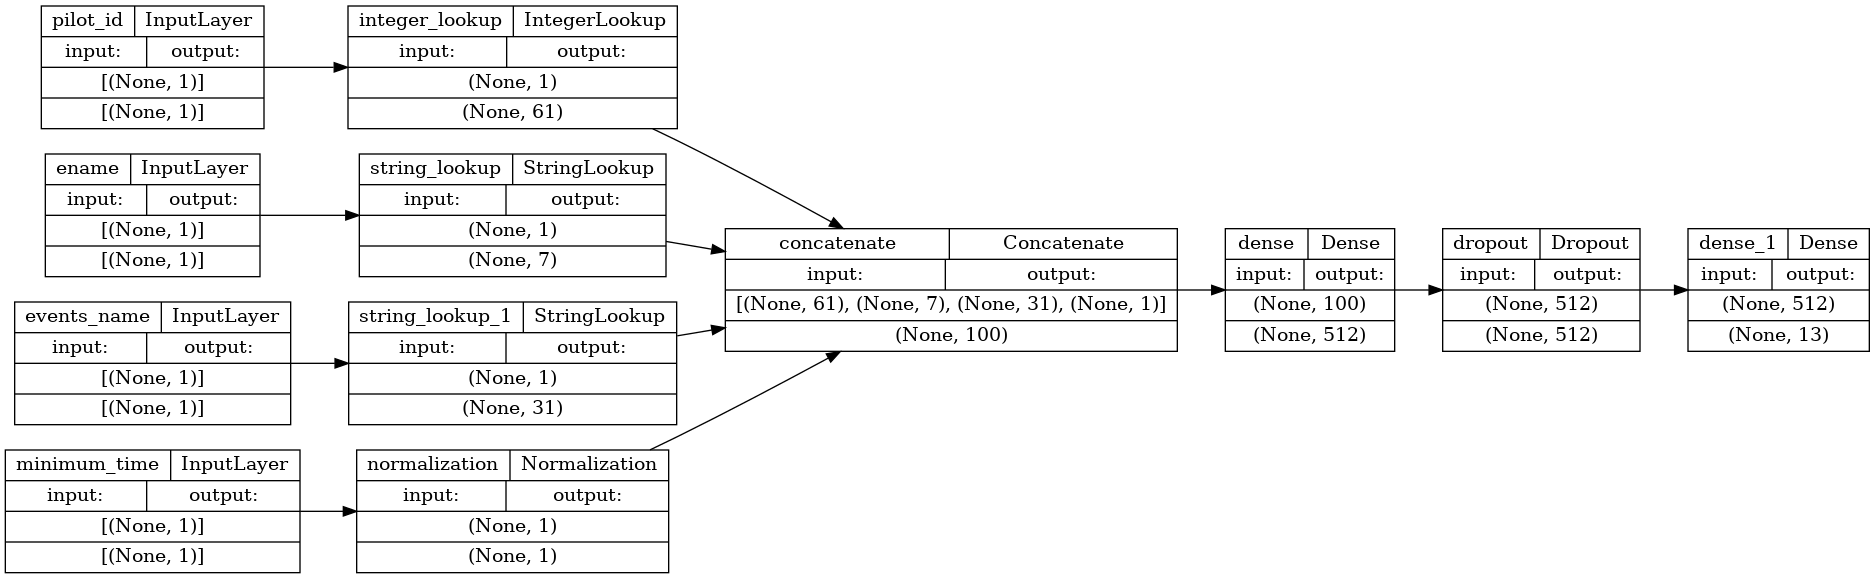

In [18]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train the Model
For now, run one epoch, only one cycle through all the data, to save the time.

In [19]:
model.fit(train_ds, epochs=1, validation_data=val_ds)

21/21 [==============================] - 2s 16ms/step - loss: 2.5657 - accuracy: 0.0757 - val_loss: 2.5489 - val_accuracy: 0.0617


### Save model
Finally, save the model. You will need it in the next steps for the Challenge.

In [21]:
model.save(f'gs://{BUCKET}/model')

INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-01-b313f4deebe2/model/assets


This saves/exports the model artifacts to the storage bucket you created at the beginning of the Challenge.

Model artifacts contain the architecture of the model (all the layers we created) and the weight, trained variables a model will use to calculate predictions.

In [22]:
!gsutil ls gs://{BUCKET}/model

gs://qwiklabs-gcp-01-b313f4deebe2/model/
gs://qwiklabs-gcp-01-b313f4deebe2/model/keras_metadata.pb
gs://qwiklabs-gcp-01-b313f4deebe2/model/saved_model.pb
gs://qwiklabs-gcp-01-b313f4deebe2/model/assets/
gs://qwiklabs-gcp-01-b313f4deebe2/model/variables/


In [24]:
 !gcloud ai models upload \
  --region=us-east1 \
  --display-name=drl-pilot-ranking \
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest \
  --artifact-uri=gs://{BUCKET}/model

Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Waiting for operation [6678436925646307328]...done.                            


In [25]:
from google.cloud import aiplatform

In [28]:
aiplatform.init(
    # your Google Cloud Project ID or number
    # environment default used is not set
    project={PROJECT},

    # the Vertex AI region you will use
    # defaults to us-central1
    location='us-east1',

    # Google Cloud Storage bucket in same region as location
    # used to stage artifacts
    staging_bucket='gs://my_staging_bucket',

    # custom google.auth.credentials.Credentials
    # environment default creds used if not set
    credentials='4/0ARtbsJpLRueN6ZdXxdfjgPeCxntGbboV4-bIv1c_gOi6Ng3eMloOVVUpGfj_Qw2qXm7Cdw',

    # customer managed encryption key resource name
    # will be applied to all Vertex AI resources if set
    # encryption_spec_key_name=my_encryption_key_name,

    # the name of the experiment to use to track
    # logged metrics and parameters
    experiment='my-experiment',

    # description of the experiment above
    experiment_description='my experiment decsription'
)

PermissionDenied: 403 Permission denied on resource project {'qwiklabs-gcp-01-b313f4deebe2'}. [links {
  description: "Google developer console API key"
  url: "https://console.developers.google.com/project/{\'qwiklabs-gcp-01-b313f4deebe2\'}/apiui/credential"
}
, reason: "CONSUMER_INVALID"
domain: "googleapis.com"
metadata {
  key: "consumer"
  value: "projects/{\'qwiklabs-gcp-01-b313f4deebe2\'}"
}
metadata {
  key: "service"
  value: "aiplatform.googleapis.com"
}
]